In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:
zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm,num_eigen=11,init_vector=None,num_Lanczos=None,iteration=None,tolerance=0)

In [6]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM02/spencer/daily_filt/filtered_vels.zarr')


#eta_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1/filtered_eta_nom.zarr')
#eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
steric2 = xr.open_zarr('/swot/SUM02/spencer/steric_inc_mean.zarr')
steric_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/steric_mean.zarr')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

eta_eul = steric2.steric-steric_mean.steric + eta_mean.Eta

frontogenesis=xr.open_zarr('/swot/SUM02/spencer/daily_filt/frontogenesis_subset.zarr')

uvel_filtered = vels_filtered.u.isel(time=slice(1,110))
vvel_filtered = vels_filtered.v.isel(time=slice(1,110))
#ssh_filtered = eta_filtered.eta.isel(time=slice(1,110))

#uvel_unfiltered = vels_unfiltered.u.isel(time=slice(2,110))
#vvel_unfiltered = vels_unfiltered.v.isel(time=slice(2,110))
#ssh_unfiltered = eta_unfiltered.eta.isel(time=slice(2,110))


#uvel_filtered = uvel_filtered.drop_vars('time')
#vvel_filtered = vvel_filtered.drop_vars('time')
#uvel_unfiltered = uvel_unfiltered.drop_vars('time')
#vvel_unfiltered = vvel_unfiltered.drop_vars('time')
grid = Grid(uvel_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 32
  **blockwise_kwargs,


In [7]:
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)

In [8]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600*1.1,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=1709
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

u_eul_unfilt = uvel_eul.U.isel(time=slice(1,1800))
v_eul_unfilt = vvel_eul.V.isel(time=slice(1,1800))

u_eul_filtered = u_eul_filtered.isel(time=slice(1,1700,24)).drop_vars('time')
v_eul_filtered = v_eul_filtered.isel(time=slice(1,1700,24)).drop_vars('time')

In [9]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
uvel_filtered = uvel_filtered.swap_dims({"i": "x0"})
uvel_filtered = uvel_filtered.swap_dims({"j": "y0"})
vvel_filtered = vvel_filtered.swap_dims({"i": "x0"})
vvel_filtered = vvel_filtered.swap_dims({"j": "y0"})
uvel_unfiltered = u_eul_unfilt.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
uvel_unfiltered = uvel_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
vvel_unfiltered = v_eul_unfilt.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
vvel_unfiltered = vvel_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})

#ssh_filtered = ssh_filtered.swap_dims({"i": "x0"})
#ssh_filtered = ssh_filtered.swap_dims({"j": "y0"})
ssh_unfiltered = eta_eul.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
ssh_unfiltered = ssh_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
ssh_unfiltered = ssh_unfiltered.isel(time=slice(43,43+nofiles))
ssh_unfiltered = ssh_unfiltered.isel(time=slice(1,1700,24)).drop_vars('time')

frontogenesis = frontogenesis.frontogenesis.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
frontogenesis = frontogenesis.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})

In [17]:
xmin=900#region b: -200#region c:+500
xmax=-900#region b: -200#region c:+500

ymin=900#region b:+750#region c: +250
ymax=-900#region b:+750#region c: +250
lons, lats = np.meshgrid(uvel_filtered.x0.isel(x0=slice(xmin,xmax)).values, uvel_filtered.y0.isel(y0=slice(ymin,ymax)).values)

In [25]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =center_point.x0.values.item(),-center_point.y0.values.item()#region b:3,32 # region c: 17,40
    #region a: center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 0, 1))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

In [26]:
x_resampled = ufunc_resample((u_eul_filtered.x0.isel(x0=slice(xmin,xmax))*xr.ones_like(u_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).isel(time=slice(0,10)))).load().T)
y_resampled = ufunc_resample((u_eul_filtered.y0.isel(y0=slice(ymin,ymax))*xr.ones_like(u_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).isel(time=slice(0,10)))).load().T)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [27]:
x_resampled.min()

<xarray.DataArray ()>
array(3.53788887)
Coordinates:
    k        int64 0

In [28]:
x_resampled.max()

<xarray.DataArray ()>
array(10.48294415)
Coordinates:
    k        int64 0

In [29]:
y_resampled.min()

<xarray.DataArray ()>
array(-45.94541821)
Coordinates:
    k        int64 0

In [30]:
y_resampled.max()

<xarray.DataArray ()>
array(-41.04812504)
Coordinates:
    k        int64 0

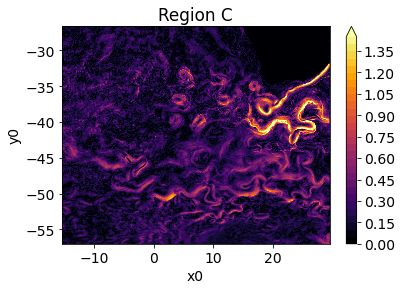

In [24]:
import matplotlib.patches as patches

speed = (uvel_unfiltered**2+vvel_unfiltered**2)**0.5
speed.isel(time=1).plot.pcolormesh(rasterized=True,levels=np.arange(0,1.5,0.05),cmap='inferno')

# Create a Rectangle patch
rect = patches.Rectangle((x_resampled.min().values, y_resampled.min().values), x_resampled.max().values
                         -x_resampled.min().values, y_resampled.max().values
                         -y_resampled.min().values, linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)

plt.title('Region C')
fig=plt.gcf()
fig.savefig('region_c.png')

In [ ]:
u_eul_resampled = ufunc_resample(u_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
v_eul_resampled = ufunc_resample(v_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
u_resampled = ufunc_resample(uvel_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
v_resampled = ufunc_resample(vvel_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())

In [ ]:
fronto_resampled = ufunc_resample(frontogenesis.squeeze().isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())

In [ ]:
fronto_resampled.isel(time=10).plot()

In [ ]:
u_resampled_unfilt = ufunc_resample(uvel_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
v_resampled_unfilt = ufunc_resample(vvel_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())

In [ ]:
u_eul_resampled = u_eul_resampled.assign_coords(x1=("x1", u_eul_resampled.x1.values)).assign_coords(y1=("y1", u_eul_resampled.y1.values))
v_eul_resampled = v_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
#eta_eul_resampled = eta_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
u_resampled = u_resampled.assign_coords(x1=("x1", u_resampled.x1.values)).assign_coords(y1=("y1", u_resampled.y1.values))
v_resampled = v_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
#eta_resampled = eta_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
u_resampled_unfilt = u_resampled_unfilt.assign_coords(x1=("x1", u_resampled_unfilt.x1.values)).assign_coords(y1=("y1", u_resampled_unfilt.y1.values))
v_resampled_unfilt = v_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))
#eta_resampled_unfilt = eta_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))

In [ ]:
u_resampled_unfilt.isel(time=1).plot()

In [ ]:
u_resampled_unfilt.isel(time=-1,x1=0).plot()

In [ ]:
v_resampled_unfilt.isel(time=1000).plot(levels=np.arange(-0.5,0.5,0.01))

In [ ]:
#for torres filter, we should actually compute the fourier transform first
with ProgressBar():
    u2_xs_unfilt = xrft.dft(u_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window='tukey').compute()#,window=True,window_correction=True
    v2_xs_unfilt = xrft.dft(v_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window='tukey').compute()#,window=True
    #u2_xs_unfilt_nowin = xrft.dft(u_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()#,window=True,window_correction=True
    #v2_xs_unfilt_nowin = xrft.dft(v_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
kx = v2_xs_unfilt.freq_x1
ky = v2_xs_unfilt.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/RdS[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600
u2_xs_tofilt = u2_xs_unfilt.where(np.abs(u2_xs_unfilt.freq_time)*xr.ones_like(u2_xs_unfilt)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofilt = v2_xs_unfilt.where(np.abs(v2_xs_unfilt.freq_time)*xr.ones_like(v2_xs_unfilt)<omegaM[:,:,10]/np.pi/2)
windows,_ = xrft.xrft._apply_window(u_resampled_unfilt.drop_vars('time'), dims=['x1','y1','time'],window_type='tukey')
vel_ps_eul_torres = (np.abs(u2_xs_tofilt)**2 + np.abs(v2_xs_tofilt)**2)*0.5/(windows**2).mean()/5825.42222222

In [ ]:
with ProgressBar():
    u2_xs_wnfilt = xrft.idft(u2_xs_tofilt.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
    v2_xs_wnfilt = xrft.idft(v2_xs_tofilt.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()

In [ ]:
u_wnfilt = (u2_xs_wnfilt/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#
v_wnfilt = (v2_xs_wnfilt/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#

u_unfilt = u_resampled_unfilt.isel(time=slice(43,1700,24))
v_unfilt = v_resampled_unfilt.isel(time=slice(43,1700,24))

In [ ]:
eta_resampled_unfilt = ufunc_resample(ssh_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(xmin,xmax)).load())

In [ ]:
tangrid = Grid(eta_resampled_unfilt, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})

In [117]:
f = 2*2*np.pi/24/3600*np.sin(y_resampled.isel(time=0)*np.pi/180)
g=9.81
tangrid.diff(eta_resampled_unfilt,'X')
u_g = (-g/f*tangrid.interp(tangrid.diff(eta_resampled_unfilt,'Y'),'Y'))/1000
v_g = (g/f*tangrid.interp(tangrid.diff(eta_resampled_unfilt,'X'),'X'))/1000

In [118]:
last_time = 70
geostrophic_speed = (u_g.isel(time=slice(0,last_time))**2 
                    + v_g.isel(time=slice(0,last_time))**2)**0.5
wnfiltered_speed = (u_wnfilt.isel(time=slice(0,last_time))**2 
                    + v_wnfilt.isel(time=slice(0,last_time))**2)**0.5
filtered_speed = (u_resampled.isel(time=slice(0,last_time))**2 
                    + v_resampled.isel(time=slice(0,last_time))**2)**0.5
eulfiltered_speed = (u_eul_resampled.isel(time=slice(0,last_time))**2 
                    + v_eul_resampled.isel(time=slice(0,last_time))**2)**0.5

In [119]:
rms_wnfiltered = ((((wnfiltered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()

rms_filtered = ((((filtered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()
rms_eulfiltered = ((((eulfiltered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()

In [ ]:
rms_wnfiltered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean()

fig=plt.figure(figsize=(10,4))

plt.subplot(131)
rms_eulfiltered.plot(levels=np.arange(0,1.5,0.01),add_colorbar=False)
plt.title('Eulerian, \n rms = %1.4f'%rms_eulfiltered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
# Create a Rectangle patch
rect = patches.Rectangle((rms_eulfiltered.x1.isel(x1=120), rms_eulfiltered.y1.isel(y1=120)), rms_eulfiltered.x1.isel(x1=-120)-rms_eulfiltered.x1.isel(x1=120),
                         rms_eulfiltered.y1.isel(y1=-120)-rms_eulfiltered.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)


plt.subplot(132)
rms_filtered.plot(levels=np.arange(0,1.5,0.01),add_colorbar=False)
plt.title('Lagrangian, \n rms = %1.4f'%rms_filtered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
plt.ylabel('')

rect = patches.Rectangle((rms_filtered.x1.isel(x1=120), rms_filtered.y1.isel(y1=120)), rms_filtered.x1.isel(x1=-120)-rms_filtered.x1.isel(x1=120),
                         rms_filtered.y1.isel(y1=-120)-rms_filtered.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)

plt.subplot(133)
cs = rms_wnfiltered.plot(levels=np.arange(0,1.5,0.01),add_colorbar=False)
plt.title('Freq/wn, \n rms = %1.4f'%rms_wnfiltered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
plt.ylabel('')

rect = patches.Rectangle((rms_wnfiltered.x1.isel(x1=120), rms_wnfiltered.y1.isel(y1=120)), rms_wnfiltered.x1.isel(x1=-120)-rms_wnfiltered.x1.isel(x1=120),
                         rms_wnfiltered.y1.isel(y1=-120)-rms_wnfiltered.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)

plt.tight_layout()

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')

fig=plt.gcf()
fig.savefig('rms_region_c.png')

In [415]:
#ffmpeg -r 60 -f image2 -i fig%03d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p vel.mp4

for tt in range(0,70):
    fig=plt.figure(figsize=(14,3.5))

    plt.subplot(141)
    u_unfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.title('Unfiltered, u')

    plt.subplot(142)
    u_eul_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Eulerian, u')

    plt.subplot(143)
    u_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Lagrangian, u')

    plt.subplot(144)
    cs = u_wnfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Freq/wn, u')

    plt.tight_layout()

    fig.subplots_adjust(right=0.9,wspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
    fig.colorbar(cs, cax=cbar_ax,extend='both')
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)
    plt.close(fig) 

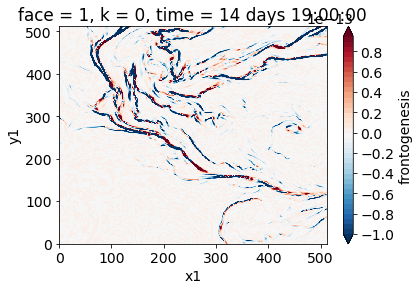

In [133]:
fronto_resampled.isel(time=10).plot(levels=np.arange(-1,1,0.05)*10**-13)

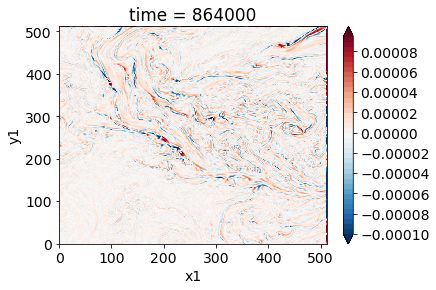

In [128]:
div_filt.isel(time=10).plot(levels=np.arange(-1,1,0.05)*10**-4)

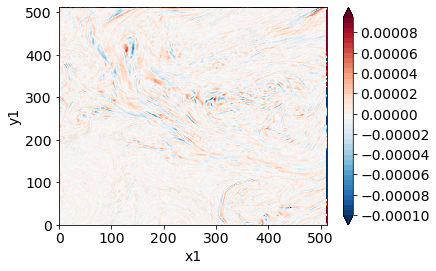

In [129]:
div_eulfilt.isel(time=10).plot(levels=np.arange(-1,1,0.05)*10**-4)

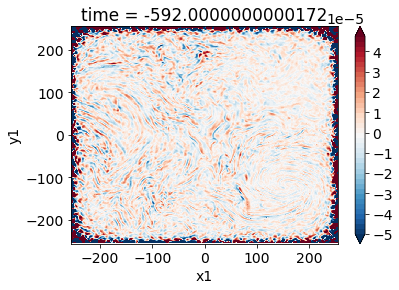

In [116]:
div_wnfilt.isel(time=10).plot(levels=np.arange(-1,1,0.05)*10**-5*5)

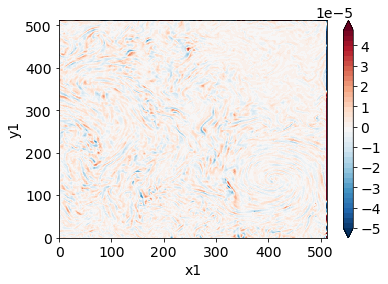

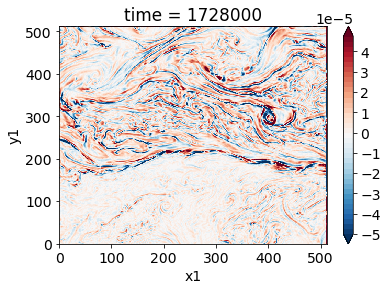

In [120]:
div_unfilt = (tangrid.interp(tangrid.diff(u_unfilt,'X'),'X')+tangrid.interp(tangrid.diff(v_unfilt,'Y'),'Y'))/1000
div_eulfilt = (tangrid.interp(tangrid.diff(u_eul_resampled,'X'),'X')+tangrid.interp(tangrid.diff(v_eul_resampled,'Y'),'Y'))/1000
div_filt = (tangrid.interp(tangrid.diff(u_resampled,'X'),'X')+tangrid.interp(tangrid.diff(v_resampled,'Y'),'Y'))/1000
div_wnfilt = (tangrid.interp(tangrid.diff(u_wnfilt,'X'),'X')+tangrid.interp(tangrid.diff(v_wnfilt,'Y'),'Y'))/1000


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1852: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1848: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)


In [134]:
for tt in range(0,70):
    fig=plt.figure(figsize=(14,7))

    plt.subplot(231)
    div_unfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.title('Unfiltered, divergence')

    plt.subplot(232)
    div_eulfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Eulerian, divergence')

    plt.subplot(233)
    div_filt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Lagrangian, divergence')

    plt.subplot(234)
    div_wnfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Freq/wn, divergence')
    
    plt.subplot(235)
    cs = fronto_resampled.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-13,add_colorbar=False)
    plt.ylabel('')
    plt.title('Frontogenesis function')

    plt.tight_layout()

    fig.subplots_adjust(right=0.9,wspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
    fig.colorbar(cs, cax=cbar_ax,extend='both')
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)
    plt.close(fig) 

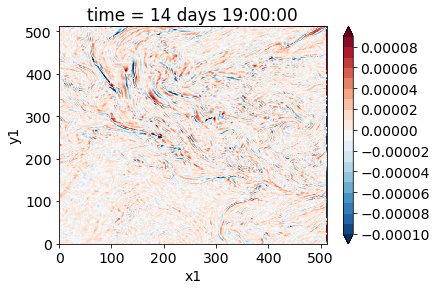

In [423]:
(div_unfilt.isel(time=10)).plot(levels=np.arange(-1,1,0.1)*10**-4)#

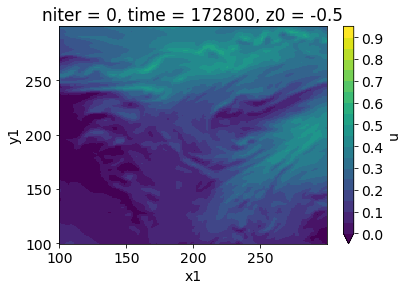

In [125]:
(u_resampled.isel(time=2)).isel(x1=slice(100,300),y1=slice(100,300)).plot(levels=np.arange(0,1,0.05),cmap='viridis')

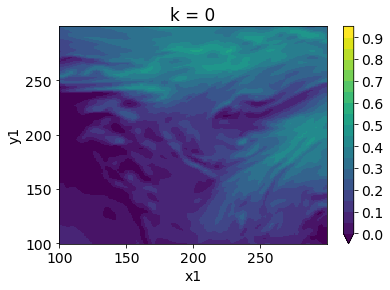

In [124]:
u_eul_resampled.isel(time=2).isel(x1=slice(100,300),y1=slice(100,300)).plot(levels=np.arange(0,1,0.05),cmap='viridis')

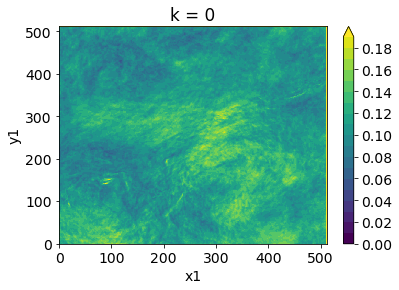

In [13]:
eta_resampled_unfilt = ufunc_resample(ssh_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(xmin,xmax)).load())
#eta_resampled = ufunc_resample(ssh_filtered.load())
eta_eul_resampled = ufunc_resample(eta_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(xmin,xmax)).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


KeyboardInterrupt: 